In [36]:
import torch
import time
import torch.nn
from torch.autograd import Variable
import torch.nn.functional as F
import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

torch.set_printoptions(precision=4, sci_mode=False)
np.set_printoptions( formatter={'float': '{: 0.4f}'.format})

In [2]:
class Trainer:
    def __init__(self, model, test_X, test_y, loss_fn, optimizer, eval_step_size=10):
        self.model = model
        self.test_X = test_X
        self.test_y = test_y
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        
        self.loss_results = []
        self.time_results = []
        self.num_steps = 0
        self.eval_step_size = eval_step_size
        
        
    def train_step(self, X, y):
        self.num_steps = self.num_steps + 1
        
        t0 = time.time()
        
        if len(self.time_results) > 0:
            min_time = self.time_results[-1]
        else:
            min_time = 0


        loss_results = []
        time_results = []


        if self.num_steps % self.eval_step_size == 1:

            if self.test_X is None:
                test_x = X
                test_y = y
            else:
                test_x = self.test_X
                test_y = self.test_y


            self.model.eval()
            # Forward pass: compute predicted y by passing x to the model.
            y_pred = self.model(test_x)

            # Compute and print loss.
            loss = self.loss_fn(y_pred, test_y)
            
            loss_results.append(loss.data.sum().tolist())
            time_results.append(int(time.time() - t0 + min_time))

        self.model.train()
        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        self.optimizer.zero_grad()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = self.model(X)

        # Compute and print loss.

        loss = self.loss_fn(y_pred, y)
        loss = loss.sum()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        self.optimizer.step()
            
        self.loss_results.extend(loss_results)
        self.time_results.extend(time_results)

In [3]:
class ListModule(torch.nn.Module):
    def __init__(self, *args):
        super(ListModule, self).__init__()
        idx = 0
        for module in args:
            self.add_module(str(idx), module)
            idx += 1

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        return iter(self._modules.values())

    def __len__(self):
        return len(self._modules)

    
    def forward(self, x):
        y = x
        for m in self:
            y = m(y)
        return y
    
    def __str__(self):
        ret = []
        for m in self:
            ret.append(str(m))
        return 'List ' + ' '.join(ret)

In [4]:
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, 
                 activation=torch.nn.LeakyReLU, final_transform=None):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(NeuralNet, self).__init__()
        self.dropout_prob = 0.2 
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation()
        self.sigmoid = torch.nn.Sigmoid()
        
        #self.drop = 
        
        last_size = input_size

        layers = []
        
        #layers.append(torch.nn.Dropout(p=self.dropout_prob))
        
        layers.append(torch.nn.BatchNorm1d(input_size))

        for size in hidden_sizes:
            n = torch.nn.Linear(int(last_size), int(size))
            layers.append(n)
            last_size = size

            layers.append(self.activation)
            layers.append(torch.nn.BatchNorm1d(size))
        
            #layers.append(torch.nn.Dropout(p=self.dropout_prob))
        
        n = torch.nn.Linear(int(last_size), int(output_size))
        layers.append(n)
        
        if final_transform:
            layers.append(final_transform)
        
        self.layers = ListModule(*layers)
        
        
    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        x = self.layers(x)
        return torch.cat([
            x[:,:-1], 
            self.sigmoid(x[:, -1:])
        ], 1)
    

In [5]:
def norm(x):
    return (x - x.mean()) / x.std(), (x.mean(), x.std())

def de_norm(x, tup):
    u, std = tup
    return (x*std) + u

In [6]:
def cdf(y):
    resample = np.random.choice(len(y), size=len(y))
    
    return np.sum(y > y[resample], axis=1) >= y.shape[1]
    
    #return np.sum(y, axis=1) > np.sum(y[resample], axis=1)

In [333]:
sz = 1000000


f1 = np.random.normal(scale=10, size=sz)
#f1 = np.random.random(size=sz)
f2 = np.random.normal(scale=10, size=sz)
f2 = np.random.random(size=sz)
#f3 = np.random.binomial(1, 0.5, size=sz)


#f2 = np.random.random(size=sz)
#
#f4 = f3 * np.random.random(size=sz) * 10
#f5 = np.random.random(size=sz)

y1 = f1**2 + f2 #+ 100 * f3
#y2 = f1 + f2

#f1, f1_param = norm(f1)
#f2, f2_param = norm(f2)

#y1 = f1 + f4
#y2 = np.log(f1) * 10 + f2 * 100 + f3 * 10 + f4 * 50
#y3 = y1 / (1 + y2)
#y4 = np.abs(f3) / (np.abs(f3)+np.abs(f5))

X = np.array([f1, f2]) #, f3])

y1, y1_param = norm(y1)
#y2 = norm(y2)
#y3 = norm(y3)
#y4 = norm(y4)

Y = np.array([y1])

cdf_x = np.array([cdf(X.transpose())])

Y = np.concatenate([Y, cdf_x])



X = X.transpose()
Y = Y.transpose()

X_tensor = torch.cuda.FloatTensor(X)
Y_tensor = torch.cuda.FloatTensor(Y)



In [334]:
net = NeuralNet(X.shape[1], [200,100, 50][:1], Y.shape[1])

In [335]:
net.cuda()
    
trainer = Trainer(net, None, None, torch.nn.MSELoss(),
                                torch.optim.Adam(net.parameters(), lr=0.01))

In [336]:
test_x, train_x = X_tensor[-5000:], X_tensor[:-5000]
test_y, train_y = Y_tensor[-5000:], Y_tensor[:-5000]

In [337]:
chunk_size = 1024
x_chunks = train_x.chunk(int(sz/chunk_size))
y_chunks = train_y.chunk(int(sz/chunk_size))

for _ in range(10):
    for x, y in zip(x_chunks, y_chunks):
        trainer.train_step(x, y)

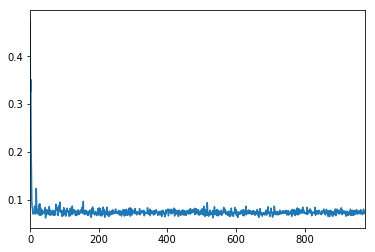

In [338]:
pd.Series(trainer.loss_results).plot()

In [339]:
net.eval()

NeuralNet(
  (activation): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
  (layers): ListModule(
    (0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=2, out_features=200, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=200, out_features=2, bias=True)
  )
)

In [340]:
test_pred = net(test_x).cpu().detach().numpy()

In [341]:
test_y

tensor([[-0.6897,  0.0000],
        [-0.6850,  0.0000],
        [-0.4299,  1.0000],
        ...,
        [-0.2259,  1.0000],
        [ 0.5897,  1.0000],
        [-0.7004,  1.0000]], device='cuda:0')

In [342]:
test_pred

array([[-0.6885,  0.3719],
       [-0.6817,  0.2695],
       [-0.4118,  0.7948],
       ...,
       [-0.1739,  0.7834],
       [ 0.6219,  0.4348],
       [-0.6822,  0.3272]], dtype=float32)

In [343]:
test_pred[:, 0].mean(), y1.mean()

(0.02547686, -1.794955295508771e-16)

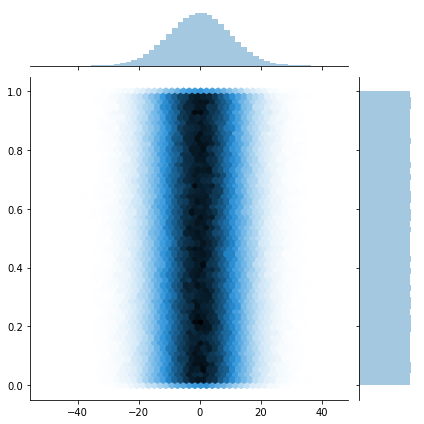

In [344]:
sns.jointplot(x=f, y=f2, kind="hex")

In [345]:
preidiction_shape = 20

f1_center = (np.max(f1) + np.min(f1)) / 2
f1_range = (np.max(f1) - np.min(f1)) / 2
f1_ticks = np.linspace(f1_center - f1_range, f1_center + f1_range, preidiction_shape)

f2_center = (np.max(f2) + np.min(f2)) / 2
f2_range = (np.max(f2) - np.min(f2)) / 2
f2_ticks =  np.linspace(f2_center - f2_range, f2_center + f2_range, preidiction_shape)


grid = []
for i1 in f1_ticks:
    for i2 in f2_ticks:
        grid.append([i1, i2])
        

In [346]:
probe_x = torch.cuda.FloatTensor(grid)
p = net(probe_x).cpu().detach().numpy()

In [347]:

true_cdf = []
interpolated_y = []

for i1, i2 in grid:
    sel = X[:,0] < i1
    sel &= X[:,1] < i2
    
    true_cdf.append(sel.mean())
    
    est_y = i1**2 + i2
    interpolated_y.append(est_y)

true_cdf = np.array(true_cdf)
interpolated_y = np.array(interpolated_y)

In [391]:
a = np.array([[0,0,0,0,0],
 [0,0,0.1,0.1,0.2],
 [0,0,.1,.3,.4],
 [0,.3,.4,.6,.85],
 [0,0.3,0.4,0.75,1]])

In [407]:
a[1:,1:]

array([[ 0.0000,  0.1000,  0.1000,  0.2000],
       [ 0.0000,  0.1000,  0.3000,  0.4000],
       [ 0.3000,  0.4000,  0.6000,  0.8500],
       [ 0.3000,  0.4000,  0.7500,  1.0000]])

In [408]:
b = a[1:,1:].copy()
ret = np.zeros(a.shape)

epsalon = 1/np.sum(b.shape) * 1/1000

for i in range(0, b.shape[0]):
    for j in range(0, b.shape[1]):
        v = b[i,j]
        if v > epsalon:
            
            b[i:,j:] -= v
            
            ret[i,j] = v
print(ret)

[[ 0.0000  0.1000  0.0000  0.1000  0.0000]
 [ 0.0000  0.0000  0.2000  0.0000  0.0000]
 [ 0.3000  0.0000  0.0000  0.1500  0.0000]
 [ 0.0000  0.0000  0.1500  0.0000  0.0000]
 [ 0.0000  0.0000  0.0000  0.0000  0.0000]]


In [396]:
cdf_to_pdf(a)[0]

array([[ 0.0000,  0.0000,  0.0312,  0.0156,  0.0469],
       [ 0.0000,  0.0000,  0.0312,  0.0156,  0.0469],
       [ 0.0000,  0.0000,  0.0156,  0.0625,  0.0469],
       [ 0.0937,  0.0937,  0.0625,  0.0781,  0.1094],
       [ 0.0469,  0.0469,  0.0156,  0.0781,  0.0625]])

In [432]:
def cdf_to_pdf(mat):
    mat = mat.copy() 
    xlen, ylen = mat.shape
    
    epsalon = 1/np.sum(mat.shape) * 1/1000

    
    for i in range(1, xlen):
        for j in range(1, ylen):
            mat[i,j] = np.max([
                mat[i,j], 
                mat[i-1,j], 
                mat[i,j-1], 
                mat[i-1,j-1]])
    
    mat = mat - mat.min()
    mat = mat / mat.max()   
    
    mat_ret = mat.copy()
    
    ret = np.zeros(mat.shape)
    
    for i in range(1, xlen):
        for j in range(1, ylen):
            
            v = mat[i,j]
            if v > epsalon:

                mat[i:,j:] -= v

                ret[i,j] = v
              
            
            

    ret = ret / ret.sum()
    
    return ret, mat_ret



In [433]:
true_cdf = true_cdf.reshape(preidiction_shape,preidiction_shape)
cdf_prediction = p[:, -1].reshape(preidiction_shape, preidiction_shape)


pdf_prediction, cdf_mod = cdf_to_pdf(cdf_prediction)

true_pdf, _ = cdf_to_pdf(true_cdf)

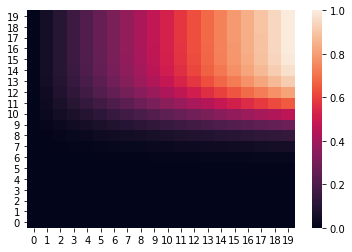

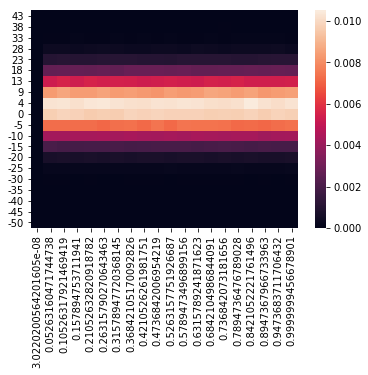

In [434]:
ax = sns.heatmap(true_cdf)
ax.invert_yaxis()
plt.show()
ax = sns.heatmap(true_pdf, xticklabels=f2_ticks, yticklabels=f1_ticks.astype(int))
ax.invert_yaxis()

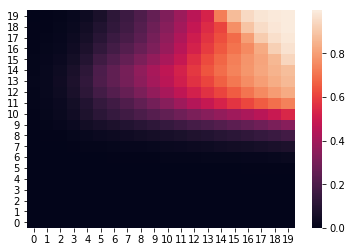

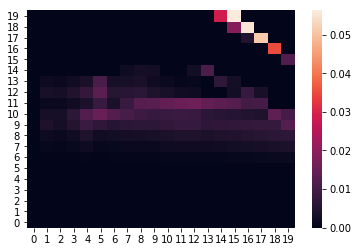

In [435]:
ax = sns.heatmap(cdf_prediction)
ax.invert_yaxis()
plt.show()
ax = sns.heatmap(pdf_prediction)
ax.invert_yaxis()

ax 0 - PDF sums to 1: 0.04999999999999999


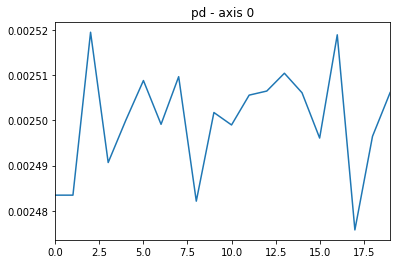

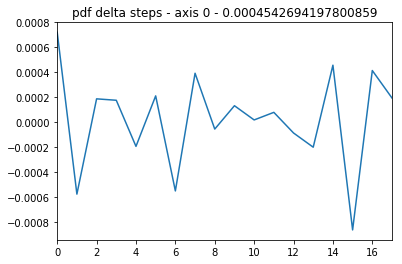

ax 1 - PDF sums to 1: 0.049999999999999996


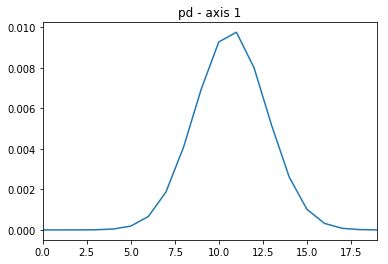

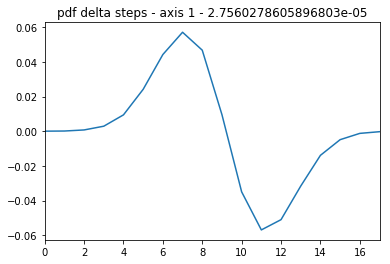

In [417]:
for ax in [0, 1]:
    pd.Series(true_pdf.mean(axis=ax)).plot(title=f'pd - axis {ax}')
    print(f'ax {ax} - PDF sums to 1: {true_pdf.mean(axis=ax).sum()}')
    plt.show()
    t = true_pdf.sum(axis=ax)[1:]

    last = t[0]
    res = []
    for tt in t[1:]:
        res.append(tt-last)
        last=tt
    pd.Series(res).plot(title=f'pdf delta steps - axis {ax} - {np.sum(res)}')
    plt.show()
    
          

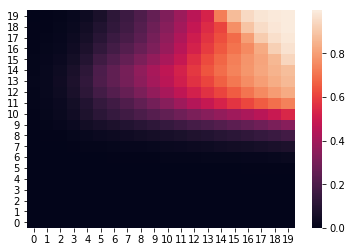

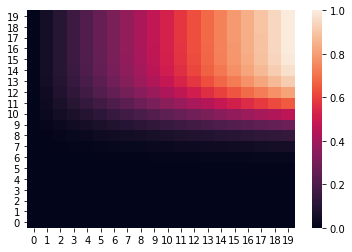

In [418]:
ax = sns.heatmap(cdf_prediction)
ax.invert_yaxis()
plt.show()
ax = sns.heatmap(true_cdf)
ax.invert_yaxis()

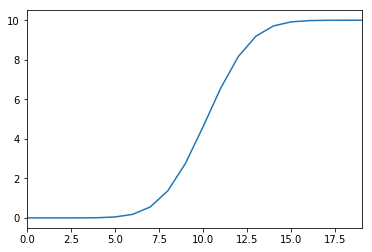

In [419]:
pd.Series(true_cdf.sum(axis=1)).plot() 

In [420]:
true_cdf.sum(axis=1)[1]

7e-06

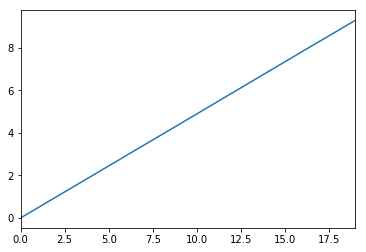

In [421]:
pd.Series(true_cdf.sum(axis=0)).plot()

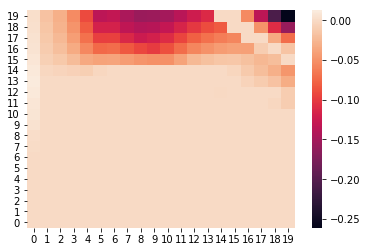

In [422]:
ax = sns.heatmap(cdf_mod)
ax.invert_yaxis()

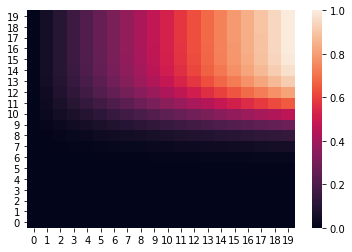

In [423]:
ax = sns.heatmap(true_cdf)
ax.invert_yaxis()

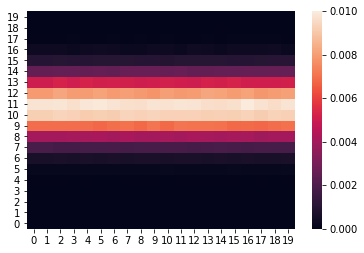

In [424]:
ax = sns.heatmap(true_pdf)
ax.invert_yaxis()

In [182]:
import matplotlib.pylab as plt

In [345]:
true_pdf.sum(axis=1)

array([ 0.0333,  0.0333,  0.0333,  0.0333,  0.0333,  0.0333,  0.0333,
        0.0333,  0.0333,  0.0333,  0.0333,  0.0333,  0.0333,  0.0333,
        0.0333,  0.0333,  0.0333,  0.0333,  0.0333,  0.0333,  0.0333,
        0.0333,  0.0333,  0.0332,  0.0332,  0.0332,  0.0332,  0.0332,
        0.0332,  0.0332])

(0, 0.2)

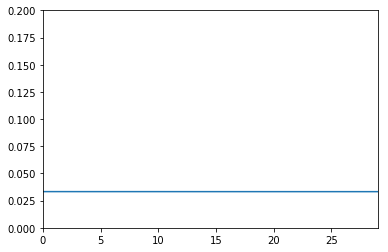

In [346]:
pd.Series(true_pdf.sum(axis=1)).plot()
plt.ylim(0, 0.2)

In [347]:
true_pdf.sum(axis=1)/10

array([ 0.0033,  0.0033,  0.0033,  0.0033,  0.0033,  0.0033,  0.0033,
        0.0033,  0.0033,  0.0033,  0.0033,  0.0033,  0.0033,  0.0033,
        0.0033,  0.0033,  0.0033,  0.0033,  0.0033,  0.0033,  0.0033,
        0.0033,  0.0033,  0.0033,  0.0033,  0.0033,  0.0033,  0.0033,
        0.0033,  0.0033])

In [348]:
true_pdf.sum()

0.9978085714659379

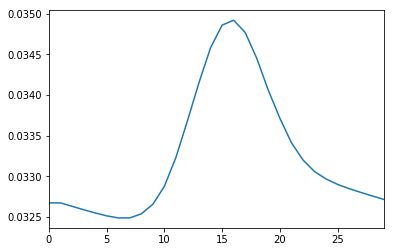

In [349]:
pd.Series(true_pdf.sum(axis=0)).plot()


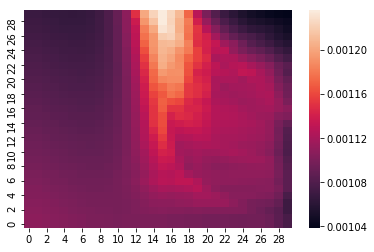

In [350]:
ax = sns.heatmap(pdf_prediction)
ax.invert_yaxis()

In [351]:
np.sum(true_pdf.reshape(-1) * interpolated_y)

-0.29964950459237166

In [352]:
np.sum(p[:,0] * pdf_prediction.reshape(-1))

-0.076238945

In [353]:
np.sum(p[:,1] * pdf_prediction.reshape(-1))

0.24595271

In [354]:
de_norm(y1, y1_param).mean()

0.3322736038624691

In [761]:
preidiction_shape = 1000

grid = []
for i1 in np.linspace(np.min(f1), np.max(f1), preidiction_shape):
    row = []
    for i2 in np.linspace(np.min(f2), np.max(f2), preidiction_shape):
        grid.append([i1, i2])
        

In [762]:
probe_x = torch.cuda.FloatTensor(grid)
p = net(probe_x).cpu().detach().numpy()

In [763]:
cdf_prediction = p[:, -1].reshape(preidiction_shape, preidiction_shape)
der = np.gradient(cdf_prediction)
pdf_prediction = np.sum(der, axis=0) 
pdf_prediction = pdf_prediction / pdf_prediction.sum()